
このノートブックを実行するには、次の追加ライブラリが必要です。 Colab での実行は実験的なものであることに注意してください。問題がある場合は、Github の問題を報告してください。


In [ ]:
!pip install d2l==1.0.0-beta0



# 複数の GPU でのトレーニング

:label: `sec_multi_gpu`

これまで、CPU と GPU でモデルを効率的にトレーニングする方法について説明しました。 :numref: `sec_auto_para`で、ディープ ラーニング フレームワークを使用して、フレームワーク間の計算と通信を自動的に並列化する方法も示しました。 :numref: `sec_use_gpu`では、 `nvidia-smi`コマンドを使用してコンピューター上で利用可能なすべての GPU を一覧表示する方法も示しました。私たちが議論しなかった*の*は、ディープラーニングトレーニングを実際に並列化する方法です。その代わりに、何らかの方法でデータを複数のデバイスに分割して機能させることを暗示しました。このセクションでは詳細を説明し、最初からネットワークを並行してトレーニングする方法を示します。高レベル API の機能を利用する方法の詳細は、 :numref: `sec_multi_gpu_concise`に移されます。 :numref: `sec_minibatch_sgd`で説明されているようなミニバッチ確率的勾配降下法アルゴリズムに精通していることを前提としています。

## 問題を分割する

単純なコンピューター ビジョンの問題と、たとえば複数の畳み込み層、プーリング、そして最終的には完全に接続されたいくつかの層を含む、少し古いネットワークから始めましょう。つまり、 LeNet :cite: `LeCun.Bottou.Bengio.ea.1998`または AlexNet :cite: `Krizhevsky.Sutskever.Hinton.2012`によく似たネットワークから始めましょう。複数の GPU (デスクトップ サーバーの場合は 2 つ、AWS g4dn.12xlarge インスタンスでは 4 つ、p3.16xlarge では 8 つ、または p2.16xlarge では 16 つ) がある場合、適切な速度向上を達成できる方法でトレーニングを分割したいと考えています。同時に、シンプルで再現可能な設計の選択肢から恩恵を受けます。結局のところ、複数の GPU は*メモリ*と*計算*能力の両方を向上させます。簡単に言うと、分類したいトレーニング データのミニバッチが与えられた場合、次の選択肢があります。

まず、ネットワークを複数の GPU に分割できます。つまり、各 GPU は特定のレイヤーに流入するデータを入力として受け取り、後続の多数のレイヤーにわたってデータを処理して、そのデータを次の GPU に送信します。これにより、単一の GPU で処理できるデータと比較して、より大規模なネットワークでデータを処理できるようになります。さらに、GPU あたりのメモリ フットプリントは適切に制御できます (ネットワーク フットプリント全体の一部です)。

ただし、レイヤー (つまり GPU) 間のインターフェイスには厳密な同期が必要です。これは、特にレイヤー間で計算ワークロードが適切に一致していない場合には、注意が必要になる可能性があります。この問題は、GPU の数が多い場合にはさらに悪化します。レイヤー間のインターフェイスには、アクティベーションやグラディエントなどの大量のデータ転送も必要です。これにより、GPU バスの帯域幅が過剰になる可能性があります。さらに、コンピューティング集約的ではあるものの、順次操作を分割することは容易ではありません。この点に関するベストエフォートについては、例:citet: `Mirhoseini.Pham.Le.ea.2017`を参照してください。これは依然として難しい問題であり、自明でない問題に対して良好な (線形) スケーリングを達成できるかどうかは不明です。複数の GPU をチェーンするための優れたフレームワークまたはオペレーティング システムのサポートがない限り、これはお勧めしません。

 2 番目に、作業を層ごとに分割できます。たとえば、単一の GPU で 64 チャネルを計算するのではなく、問題を 4 つの GPU に分割し、それぞれが 16 チャネルのデータを生成することができます。同様に、完全に接続された層の場合、出力ユニットの数を分割できます。 :numref: `fig_alexnet_original` (:citet: `Krizhevsky.Sutskever.Hinton.2012`から取得) はこの設計を示しており、この戦略はメモリ フットプリントが非常に小さい (当時 2 GB) GPU に対処するために使用されています。これにより、チャネル (またはユニット) の数が少なすぎない限り、計算に関して適切なスケーリングが可能になります。さらに、利用可能なメモリが線形に拡張されるため、複数の GPU でますます大規模なネットワークを処理できます。 

![](../img/alexnet-original.svg) :label: `fig_alexnet_original`

ただし、各層は他のすべての層からの結果に依存するため、*非常に多くの*同期またはバリア操作が必要になります。さらに、転送する必要があるデータの量は、GPU 全体にレイヤーを分散する場合よりもさらに大きくなる可能性があります。したがって、帯域幅のコストと複雑さのため、このアプローチはお勧めしません。

最後に、複数の GPU にデータを分割できます。このようにして、すべての GPU は、異なる観測結果に基づいてでも、同じ種類の作業を実行します。トレーニング データの各ミニバッチの後に、GPU 全体で勾配が集約されます。これは最もシンプルなアプローチであり、あらゆる状況に適用できます。各ミニバッチの後にのみ同期する必要があります。そうは言っても、他のパラメータがまだ計算されている間に、すでに勾配パラメータの交換を開始することが非常に望ましいです。さらに、GPU の数が増えるとミニバッチ サイズも大きくなり、トレーニング効率が向上します。ただし、GPU を追加しても、より大きなモデルをトレーニングすることはできません。 

![](http://d2l.ai/_images/splitting.svg) :label: `fig_splitting`

複数の GPU でのさまざまな並列化方法の比較を :numref: `fig_splitting`に示します。十分に大きなメモリを備えた GPU にアクセスできる場合、概して、データ並列処理が最も便利な方法です。分散トレーニングのパーティショニングの詳細については、:cite: `Li.Andersen.Park.ea.2014`も参照してください。深層学習の初期には、GPU メモリが問題でした。現在、この問題は、最も特殊なケースを除いてすべて解決されています。以下ではデータの並列性に焦点を当てます。

## データの並列処理

マシン上に $k$ GPU があると仮定します。トレーニング対象のモデルが与えられると、各 GPU はモデル パラメーターの完全なセットを個別に維持しますが、GPU 全体のパラメーター値は同一で同期されています。例として、:numref: `fig_data_parallel` $k=2$ の場合のデータ並列処理によるトレーニングを示しています。 

![](../img/data-parallel.svg) :label: `fig_data_parallel`

一般に、トレーニングは次のように進行します。
- トレーニングの反復では、ランダムなミニバッチが与えられた場合、バッチ内のサンプルを $k$ 部分に分割し、それらを GPU 全体に均等に分散します。
- 各 GPU は、割り当てられたミニバッチ サブセットに基づいてモデル パラメーターの損失と勾配を計算します。
- 各 $k$ GPU のローカル勾配が集約されて、現在のミニバッチの確率的勾配が取得されます。
- 集約された勾配は各 GPU に再分配されます。
- 各 GPU は、このミニバッチの確率的勾配を使用して、維持するモデル パラメーターの完全なセットを更新します。

実際には、$k$ GPU でトレーニングする場合、単一の GPU のみでトレーニングしている場合と各 GPU が同じ量の作業を行うように、ミニバッチ サイズを $k$ 倍*に増やすこと*に注意してください。 16 GPU サーバーでは、これによりミニバッチ サイズが大幅に増加する可能性があるため、それに応じて学習率を増加する必要がある場合があります。また、:numref: `sec_batch_norm`のバッチ正規化は、GPU ごとに個別のバッチ正規化係数を保持するなどして調整する必要があることにも注意してください。以下では、トイ ネットワークを使用してマルチ GPU トレーニングを説明します。


In [1]:
%matplotlib inline
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l


## [**おもちゃのネットワーク**]

 :numref: `sec_lenet`で紹介されている LeNet を (わずかに変更して) 使用します。パラメーターの交換と同期を詳細に説明するために、これを最初から定義します。


In [2]:
# Initialize model parameters
scale = 0.01
W1 = torch.randn(size=(20, 1, 3, 3)) * scale
b1 = torch.zeros(20)
W2 = torch.randn(size=(50, 20, 5, 5)) * scale
b2 = torch.zeros(50)
W3 = torch.randn(size=(800, 128)) * scale
b3 = torch.zeros(128)
W4 = torch.randn(size=(128, 10)) * scale
b4 = torch.zeros(10)
params = [W1, b1, W2, b2, W3, b3, W4, b4]

# Define the model
def lenet(X, params):
    h1_conv = F.conv2d(input=X, weight=params[0], bias=params[1])
    h1_activation = F.relu(h1_conv)
    h1 = F.avg_pool2d(input=h1_activation, kernel_size=(2, 2), stride=(2, 2))
    h2_conv = F.conv2d(input=h1, weight=params[2], bias=params[3])
    h2_activation = F.relu(h2_conv)
    h2 = F.avg_pool2d(input=h2_activation, kernel_size=(2, 2), stride=(2, 2))
    h2 = h2.reshape(h2.shape[0], -1)
    h3_linear = torch.mm(h2, params[4]) + params[5]
    h3 = F.relu(h3_linear)
    y_hat = torch.mm(h3, params[6]) + params[7]
    return y_hat

# Cross-entropy loss function
loss = nn.CrossEntropyLoss(reduction='none')


## データの同期

効率的なマルチ GPU トレーニングには 2 つの基本的な操作が必要です。まず、 [**パラメータのリストを複数のデバイスに配布**] し、グラデーションをアタッチする ( `get_params` ) 機能が必要です。パラメーターがなければ、GPU でネットワークを評価することはできません。次に、複数のデバイスにわたるパラメータを合計する機能が必要です。つまり、 `allreduce`関数が必要です。


In [3]:
def get_params(params, device):
    new_params = [p.to(device) for p in params]
    for p in new_params:
        p.requires_grad_()
    return new_params


モデルのパラメーターを 1 つの GPU にコピーして試してみましょう。


In [4]:
new_params = get_params(params, d2l.try_gpu(0))
print('b1 weight:', new_params[1])
print('b1 grad:', new_params[1].grad)

b1 weight: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0', requires_grad=True)
b1 grad: None



まだ計算を実行していないため、バイアス パラメーターに関する勾配はまだゼロです。ここで、複数の GPU に分散されたベクトルがあると仮定しましょう。次の [ **`allreduce`関数はすべてのベクトルを加算し、結果をすべての GPU にブロードキャストします**]。これを機能させるには、結果を蓄積するデバイスにデータをコピーする必要があることに注意してください。


In [5]:
def allreduce(data):
    for i in range(1, len(data)):
        data[0][:] += data[i].to(data[0].device)
    for i in range(1, len(data)):
        data[i][:] = data[0].to(data[i].device)


さまざまなデバイス上でさまざまな値を持つベクトルを作成し、それらを集約することでこれをテストしてみましょう。


In [6]:
data = [torch.ones((1, 2), device=d2l.try_gpu(i)) * (i + 1) for i in range(2)]
print('before allreduce:\n', data[0], '\n', data[1])
allreduce(data)
print('after allreduce:\n', data[0], '\n', data[1])

before allreduce:
 tensor([[1., 1.]], device='cuda:0') 
 tensor([[2., 2.]], device='cuda:1')
after allreduce:
 tensor([[3., 3.]], device='cuda:0') 
 tensor([[3., 3.]], device='cuda:1')



## データの配布

[**複数の GPU に均等にミニバッチを分散する**] ための単純なユーティリティ関数が必要です。たとえば、2 つの GPU で、データの半分をいずれかの GPU にコピーしたいとします。より便利で簡潔なため、深層学習フレームワークの組み込み関数を使用して $4 \times 5$ 行列で試します。


In [7]:
data = torch.arange(20).reshape(4, 5)
devices = [torch.device('cuda:0'), torch.device('cuda:1')]
split = nn.parallel.scatter(data, devices)
print('input :', data)
print('load into', devices)
print('output:', split)

input : tensor([[ 0,  1,  2,  3,  4],
        [ 5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19]])
load into [device(type='cuda', index=0), device(type='cuda', index=1)]
output: (tensor([[0, 1, 2, 3, 4],
        [5, 6, 7, 8, 9]], device='cuda:0'), tensor([[10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19]], device='cuda:1'))



後で再利用できるように、データとラベルの両方を分割する`split_batch`関数を定義します。


In [8]:
#@save
def split_batch(X, y, devices):
    """Split `X` and `y` into multiple devices."""
    assert X.shape[0] == y.shape[0]
    return (nn.parallel.scatter(X, devices),
            nn.parallel.scatter(y, devices))


## トレーニング

これで、[**単一のミニバッチでのマルチ GPU トレーニング**] を実装できるようになりました。その実装は主に、このセクションで説明するデータ並列処理アプローチに基づいています。先ほど説明した補助関数`allreduce`と`split_and_load`を使用して、複数の GPU 間でデータを同期します。並列処理を実現するために特定のコードを記述する必要はないことに注意してください。計算グラフにはミニバッチ内のデバイス間の依存関係がないため、*自動的*に並列実行されます。


In [9]:
def train_batch(X, y, device_params, devices, lr):
    X_shards, y_shards = split_batch(X, y, devices)
    # Loss is calculated separately on each GPU
    ls = [loss(lenet(X_shard, device_W), y_shard).sum()
          for X_shard, y_shard, device_W in zip(
              X_shards, y_shards, device_params)]
    for l in ls:  # Backpropagation is performed separately on each GPU
        l.backward()
    # Sum all gradients from each GPU and broadcast them to all GPUs
    with torch.no_grad():
        for i in range(len(device_params[0])):
            allreduce([device_params[c][i].grad for c in range(len(devices))])
    # The model parameters are updated separately on each GPU
    for param in device_params:
        d2l.sgd(param, lr, X.shape[0]) # Here, we use a full-size batch


これで、[**トレーニング関数**] を定義できます。これは、前の章で使用したものとは少し異なります。GPU を割り当て、すべてのモデル パラメーターをすべてのデバイスにコピーする必要があります。明らかに、各バッチは、複数の GPU を処理する`train_batch`関数を使用して処理されます。便宜上 (およびコードの簡潔さのために) 単一の GPU で精度を計算しますが、他の GPU がアイドル状態であるため、これは*非効率的*です。


In [10]:
def train(num_gpus, batch_size, lr):
    train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
    devices = [d2l.try_gpu(i) for i in range(num_gpus)]
    # Copy model parameters to `num_gpus` GPUs
    device_params = [get_params(params, d) for d in devices]
    num_epochs = 10
    animator = d2l.Animator('epoch', 'test acc', xlim=[1, num_epochs])
    timer = d2l.Timer()
    for epoch in range(num_epochs):
        timer.start()
        for X, y in train_iter:
            # Perform multi-GPU training for a single minibatch
            train_batch(X, y, device_params, devices, lr)
            torch.cuda.synchronize()
        timer.stop()
        # Evaluate the model on GPU 0
        animator.add(epoch + 1, (d2l.evaluate_accuracy_gpu(
            lambda x: lenet(x, device_params[0]), test_iter, devices[0]),))
    print(f'test acc: {animator.Y[0][-1]:.2f}, {timer.avg():.1f} sec/epoch '
          f'on {str(devices)}')


これが [**単一の GPU 上で**] どれだけうまく機能するかを見てみましょう。まず、バッチ サイズ 256 と学習率 0.2 を使用します。


test acc: 0.84, 4.1 sec/epoch on [device(type='cuda', index=0)]


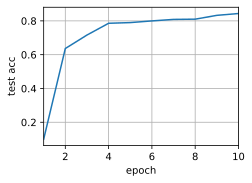

In [11]:
train(num_gpus=1, batch_size=256, lr=0.2)


バッチ サイズと学習率を変更せず、[ **GPU の数を 2 に増やす**] ことで、テスト精度は前の実験とほぼ同じままであることがわかります。最適化アルゴリズムの点では、これらは同一です。残念ながら、ここでは意味のある高速化は得られません。単にモデルが小さすぎるためです。さらに、私たちは小さなデータセットしか持っていないため、マルチ GPU トレーニングを実装するためのやや単純なアプローチでは、Python の大幅なオーバーヘッドが発生しました。今後、より複雑なモデルやより洗練された並列化方法が登場するでしょう。それでも、Fashion-MNIST に何が起こるか見てみましょう。


test acc: 0.83, 4.6 sec/epoch on [device(type='cuda', index=0), device(type='cuda', index=1)]


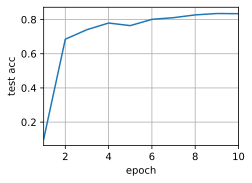

In [12]:
train(num_gpus=2, batch_size=256, lr=0.2)


## まとめ
- ディープ ネットワーク トレーニングを複数の GPU に分割するには、複数の方法があります。レイヤー間、レイヤー間、またはデータ間でそれらを分割することができます。前の 2 つは、厳密に計画されたデータ転送を必要とします。データの並列処理は最も単純な戦略です。
- データの並列トレーニングは簡単です。ただし、効率を高めるために、有効なミニバッチ サイズが増加します。
- データ並列処理では、データが複数の GPU に分割され、各 GPU が独自の順方向および逆方向の操作を実行し、その後勾配が集約されて結果が GPU にブロードキャストされます。
- より大きなミニバッチの場合は、わずかに増加した学習率を使用する場合があります。

## 演習
1. $k$ GPU でトレーニングする場合、ミニバッチ サイズを $b$ から $k \cdot b$ に変更します。つまり、GPU の数だけスケールアップします。
1. さまざまな学習率の精度を比較します。 GPU の数に応じてどのように拡張されますか?
1. 異なる GPU 上の異なるパラメータを集約する、より効率的な`allreduce`関数を実装しますか?なぜ効率が良いのでしょうか?
1. マルチ GPU テスト精度計算を実装します。



[ディスカッション](https://discuss.d2l.ai/t/1669)
